In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

import category_encoders as ce

In [11]:
df = pd.read_csv('../data/df_clean_nulls2.csv', index_col=0).drop(columns='city')
df.head()

,enrollee_id,city_development_index,gender,relevent_experience,enrolled_university,education_level,major,company_size,company_type,last_new_job,training_hours,target,exp_range,city_group
0,8949,0.920,Male,1,no_enrollment,Graduate,STEM,NaN,NaN,1,36,1.0,>20,city_103
1,29725,0.776,Male,0,no_enrollment,Graduate,STEM,50-99,private_limited,>4,47,0.0,11-15,other
2,11561,0.624,NaN,0,full_time,Graduate,STEM,NaN,NaN,never,83,0.0,2-5,city_21
3,33241,0.789,NaN,0,NaN,Graduate,Business Degree,NaN,private_limited,never,52,1.0,<=1,other
4,666,0.767,Male,1,no_enrollment,Masters,STEM,50-99,startup_funded,4,8,0.0,>20,other


In [12]:
df.shape

(20409, 14)

In [13]:
pd.options.mode.chained_assignment = None

# I. Categorical Imputing

In [14]:
perc_na = round(df.isna().sum() * 100 / len(df), 2)

pd.DataFrame({'Total NA':df.isna().sum(), '% NA':perc_na})

,Total NA,% NA
enrollee_id,0,0.00
city_development_index,0,0.00
gender,4332,21.23
relevent_experience,0,0.00
enrolled_university,235,1.15
education_level,199,0.98
major,2376,11.64
company_size,5717,28.01
company_type,5924,29.03
last_new_job,268,1.31


### a) Gender

About one fifth of all gender responses are missing. These can be imputed as a new category, 'Unknown'.

In [15]:
df['gender'].fillna('Unknown', inplace=True)
df['gender'].value_counts()

Male       14503
Unknown     4332
Female      1368
Other        206
Name: gender, dtype: int64

### b) Company Size and Type

As noted in the EDA notebook, the company size and type columns are missing nearly 30% of values. It is highly likely that candidates with missing company size and type information have either never had a job or are currently unemployed. Missing values will be imputed separately:

- 'N/A' for candidates who have never had a job
- 'Unknown' for all other missing values.

In [16]:
# Impute company size and type for applicants who've never had a previous job
df['company_size'] = np.where(df['last_new_job']=='never', 'N/A', df['company_size'])
df['company_type'] = np.where(df['last_new_job']=='never', 'N/A', df['company_type'])

# As there are still many missing values for these columns, impute all missing with 'unknown', as they can represent
# candidates who are currently unemployed
df['company_size'] = np.where(df['company_size'].isna(), 'Unknown', df['company_size'])
df['company_type'] = np.where(df['company_type'].isna(), 'Unknown', df['company_type'])

In [17]:
df[['company_size', 'company_type']].value_counts().head()

company_size  company_type   
Unknown       Unknown            3807
N/A           N/A                2296
50-99         private_limited    2278
100-499       private_limited    1992
10000+        private_limited    1819
dtype: int64

### c) Major

Additionally, missing values of major may be the result of some candidates not having attended college.

In [18]:
# Education levels across missing values of major
df.loc[df['major'].isna()]['education_level'].value_counts()

High School       1891
Primary School     267
Graduate            14
Masters              5
Name: education_level, dtype: int64

In [19]:
# Fill in 'N/A' for high school and primary school level candidates
df['major'] = np.where(df['education_level'].isin(['High School', 'Primary School']), 'N/A', df['major'])
df['major'].value_counts()

STEM               15994
N/A                 2158
Humanities           745
Other                419
Business Degree      363
Arts                 269
No Major             243
Name: major, dtype: int64

### d) Visualize Changes

In [20]:
def cat_bar(cols, idx, y, data, figsize=(20,30)):
    """Plot bar graphs that: a) compare mean values of a target to different levels of a column
    b) compare different levels of a column to different levels of a target"""
    fig, axes = plt.subplots(len(cols),2, figsize=figsize)
    fig.subplots_adjust(wspace=0.2, hspace=0.5)
    
    for i, col in enumerate(zip(cols,idx)):
        ax = axes.flatten()[i]
        
        # Percentage pos plot
        plot1 = sns.barplot(x=col[0], y=y, data=data, order=col[1], ax=axes[i,0])
        plot1.set_xticklabels(plot1.get_xticklabels(), rotation=30)
        
        # Grouped bar plot
        bar_df = data.groupby([col[0], y]).size().reset_index().pivot(
            columns=y, index=col[0], values=0).reindex(col[1])
        bar_df.plot(kind='bar', rot=30, stacked=True, ax=axes[i,1],
                    title='Group counts based on target value')

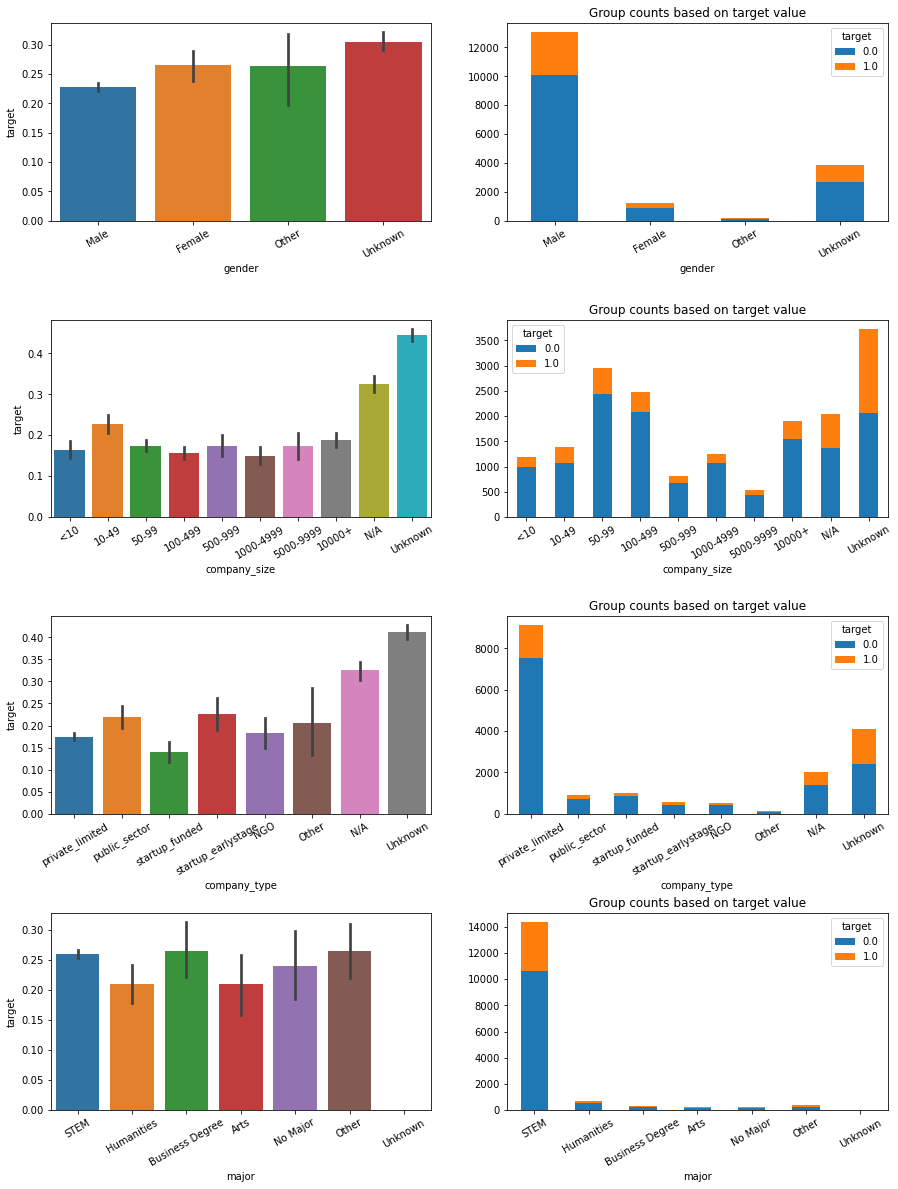

In [21]:
imp_cols = ['gender', 'company_size', 'company_type', 'major']

# For reindexing cols
gender = ['Male', 'Female', 'Other', 'Unknown']
comp_sz = ['<10','10-49','50-99','100-499','500-999','1000-4999','5000-9999','10000+', 'N/A', 'Unknown']
comp_type = ['private_limited', 'public_sector', 'startup_funded', 'startup_earlystage', 'NGO', 'Other', 'N/A', 'Unknown']
major = ['STEM', 'Humanities', 'Business Degree', 'Arts', 'No Major', 'Other', 'Unknown']

imp_idx = [gender, comp_sz, comp_type, major]

cat_bar(imp_cols, imp_idx, 'target', df, figsize=(15,20))

# II. Train Test Split

First, I'll separate the pre-defined train and test sets. This test set does not include the target feature, and therefore cannot be used for training or validation.

In [22]:
# Separate pre-defined train and tests set

main_df = df.loc[df['target'].notna()]
final_eval_df = df.loc[df['target'].isna()]

main_df.shape, final_eval_df.shape

((18280, 14), (2129, 14))

In [23]:
# Split into test/train

train, test = train_test_split(main_df, random_state=0)
train.shape, test.shape

((13710, 14), (4570, 14))

# III. Encoding Categorical Columns

In [24]:
train.dtypes[train.dtypes=='object']

gender                 object
enrolled_university    object
education_level        object
major                  object
company_size           object
company_type           object
last_new_job           object
exp_range              object
city_group             object
dtype: object

### a) Ordinal Columns

In [25]:
ord_cols = ['education_level', 'company_size', 'last_new_job', 'exp_range']

In [26]:
train['company_size'].value_counts()

Unknown      2797
50-99        2206
100-499      1811
N/A          1540
10000+       1406
10-49        1091
1000-4999     954
<10           902
500-999       603
5000-9999     400
Name: company_size, dtype: int64

In [27]:
ord_map = [
    {'col': 'education_level',
    'mapping': {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}},
    {'col': 'company_size',
     'mapping': {'N/A':0, 'Unknown':1, '<10':2, '10-49':3, '50-99':4, '100-499':5,
                 '500-999':6, '1000-4999':7, '5000-9999':8, '10000+':9}},
    {'col': 'last_new_job',
     'mapping': {'never': 0, '1': 1, '2': 2, '3':3, '4':4, '>4':5}},
    {'col': 'exp_range', 
     'mapping': {'<=1':0, '2-5':1, '6-10':2, '11-15':3, '16-20':4,'>20':5}}
]

In [28]:
ord_encoder = ce.OrdinalEncoder(
    cols=ord_cols, mapping=ord_map, return_df=True,
    handle_unknown='return_nan', handle_missing='return_nan'
)

ord_encoder.fit(train)

train = ord_encoder.transform(train)
test = ord_encoder.transform(test)
final_eval_df = ord_encoder.transform(final_eval_df)

In [29]:
train.shape, test.shape, final_eval_df.shape

((13710, 14), (4570, 14), (2129, 14))

In [30]:
# Original df

main_df[ord_cols].loc[[2913, 13038, 13226, 10167, 16867]]

,education_level,company_size,last_new_job,exp_range
2913,Masters,10-49,1,2-5
13038,Masters,10000+,2,6-10
13226,Graduate,10-49,1,2-5
10167,Primary School,N/A,never,<=1
16867,Graduate,50-99,4,>20


In [31]:
# Encoded df

train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
15092,3.0,1.0,1.0,4.0
16142,2.0,4.0,5.0,3.0
12707,2.0,5.0,1.0,1.0
134,1.0,0.0,0.0,1.0
9522,2.0,4.0,1.0,1.0


In [32]:
train[ord_cols].dtypes

education_level    float64
company_size       float64
last_new_job       float64
exp_range          float64
dtype: object

Looks good. After imputing missing values, these columns will be converted to int.

### b) One-Hot Encode Columns

In [33]:
cat_cols = ['gender', 'city_group', 'enrolled_university', 'major', 'company_type']

In [34]:
oh_encoder = ce.OneHotEncoder(cols=cat_cols, return_df=True, use_cat_names=True,
                           handle_unknown='return_nan', handle_missing='return_nan')

oh_encoder.fit(train)

train = oh_encoder.transform(train)
test = oh_encoder.transform(test)
final_eval_df = oh_encoder.transform(final_eval_df)

In [35]:
train.shape, test.shape, final_eval_df.shape

((13710, 53), (4570, 53), (2129, 53))

In [36]:
# Create new list of cat_cols

cat_cols2 = []
for i in cat_cols:
    for col_name in train.columns:
        if i in col_name:
            cat_cols2.append(col_name)
cat_cols2

['gender_Male',
 'gender_Unknown',
 'gender_Female',
 'gender_Other',
 'gender_nan',
 'city_group_other',
 'city_group_city_16',
 'city_group_city_102',
 'city_group_city_21',
 'city_group_city_160',
 'city_group_city_114',
 'city_group_city_103',
 'city_group_city_136',
 'city_group_city_100',
 'city_group_city_75',
 'city_group_city_104',
 'city_group_city_67',
 'city_group_city_71',
 'city_group_city_73',
 'city_group_city_61',
 'city_group_city_28',
 'city_group_city_11',
 'city_group_nan',
 'enrolled_university_part_time',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_nan',
 'major_STEM',
 'major_Arts',
 'major_N/A',
 'major_Humanities',
 'major_Business Degree',
 'major_No Major',
 'major_nan',
 'major_Other',
 'company_type_Unknown',
 'company_type_private_limited',
 'company_type_N/A',
 'company_type_startup_funded',
 'company_type_NGO',
 'company_type_public_sector',
 'company_type_startup_earlystage',
 'company_type_Other',
 'co

In [37]:
# Original df

main_df[cat_cols].head()

,gender,city_group,enrolled_university,major,company_type
0,Male,city_103,no_enrollment,STEM,Unknown
1,Male,other,no_enrollment,STEM,private_limited
2,Unknown,city_21,full_time,STEM,N/A
3,Unknown,other,NaN,Business Degree,N/A
4,Male,other,no_enrollment,STEM,startup_funded


In [38]:
# After encoding

train[cat_cols2].head()

,gender_Male,gender_Unknown,gender_Female,gender_Other,gender_nan,city_group_other,city_group_city_16,city_group_city_102,city_group_city_21,city_group_city_160,...,major_Other,company_type_Unknown,company_type_private_limited,company_type_N/A,company_type_startup_funded,company_type_NGO,company_type_public_sector,company_type_startup_earlystage,company_type_Other,company_type_nan
15092,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16142,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12707,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### c) Ensure all column dtypes are correct

In [39]:
train.select_dtypes(exclude='number').sum()

Series([], dtype: float64)

# IV. Imputing Remaining Nulls with KNN

The remaining missing values will be imputed with a KNN imputer.

### a) Ordinal Columns

In [41]:
# Number of NAs in each column

perc_na = round(train[ord_cols].isna().sum() * 100 / len(train[ord_cols]), 2)

pd.DataFrame({'Total NA':train[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,116,0.85
company_size,0,0.00
last_new_job,163,1.19
exp_range,26,0.19


In [42]:
# Number of NAs in each column

perc_na = round(test[ord_cols].isna().sum() * 100 / len(test[ord_cols]), 2)

pd.DataFrame({'Total NA':test[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,31,0.68
company_size,0,0.00
last_new_job,65,1.42
exp_range,7,0.15


In [44]:
KNN_ord = KNNImputer()

KNN_ord.fit(train[ord_cols])

train[ord_cols] = KNN_ord.transform(train[ord_cols])
test[ord_cols] = KNN_ord.transform(test[ord_cols])
final_eval_df[ord_cols] = KNN_ord.transform(final_eval_df[ord_cols])

In [45]:
train[ord_cols].isna().sum()

education_level    0
company_size       0
last_new_job       0
exp_range          0
dtype: int64

In [46]:
# Convert ord cols to int

train[ord_cols] = round(train[ord_cols], 0)
test[ord_cols] = round(test[ord_cols], 0)
final_eval_df[ord_cols] = round(final_eval_df[ord_cols], 0)

train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
15092,3.0,1.0,1.0,4.0
16142,2.0,4.0,5.0,3.0
12707,2.0,5.0,1.0,1.0
134,1.0,0.0,0.0,1.0
9522,2.0,4.0,1.0,1.0


The distributions don't seem to have changed.

In [47]:
# Convert ord cols to int

train[ord_cols] = train[ord_cols].astype('int64')
test[ord_cols] = test[ord_cols].astype('int64')
final_eval_df[ord_cols] = final_eval_df[ord_cols].astype('int64')

### b) One-Hot Columns

In [49]:
# Number of NAs in each column

perc_na = round(train[cat_cols2].isna().sum() * 100 / len(train[cat_cols2]), 2)

pd.DataFrame({'Total NA':train[cat_cols2].isna().sum(), '% NA':perc_na})

,Total NA,% NA
gender_Male,0,0.00
gender_Unknown,0,0.00
gender_Female,0,0.00
gender_Other,0,0.00
gender_nan,0,0.00
city_group_other,0,0.00
city_group_city_16,0,0.00
city_group_city_102,0,0.00
city_group_city_21,0,0.00
city_group_city_160,0,0.00


In [58]:
gender_cols = ['gender_Male', 'gender_Female', 'gender_Other', 'gender_Unknown']
enrolled_cols = ['enrolled_university_no_enrollment', 'enrolled_university_full_time', 'enrolled_university_part_time']
major_cols = ['major_STEM', 'major_Business Degree', 'major_Arts', 'major_Humanities',
              'major_No Major', 'major_Other', 'major_N/A']
company = ['company_type_private_limited', 'company_type_startup_funded', 'company_type_startup_earlystage', 
           'company_type_Other', 'company_type_public_sector', 'company_type_NGO', 'company_type_Unknown', 
           'company_type_N/A']

In [51]:
nan_cols = ['gender_nan', 'city_group_nan', 'enrolled_university_nan', 'major_nan', 'company_type_nan']

# Remove NaN columns from catcols2
[cat_cols2.remove(i) for i in nan_cols]

# Remove NaN cols from df
train.drop(columns=nan_cols, inplace=True)
test.drop(columns=nan_cols, inplace=True)
final_eval_df.drop(columns=nan_cols, inplace=True)

['gender_Male',
 'gender_Unknown',
 'gender_Female',
 'gender_Other',
 'city_group_other',
 'city_group_city_16',
 'city_group_city_102',
 'city_group_city_21',
 'city_group_city_160',
 'city_group_city_114',
 'city_group_city_103',
 'city_group_city_136',
 'city_group_city_100',
 'city_group_city_75',
 'city_group_city_104',
 'city_group_city_67',
 'city_group_city_71',
 'city_group_city_73',
 'city_group_city_61',
 'city_group_city_28',
 'city_group_city_11',
 'enrolled_university_part_time',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'major_STEM',
 'major_Arts',
 'major_N/A',
 'major_Humanities',
 'major_Business Degree',
 'major_No Major',
 'major_Other',
 'company_type_Unknown',
 'company_type_private_limited',
 'company_type_N/A',
 'company_type_startup_funded',
 'company_type_NGO',
 'company_type_public_sector',
 'company_type_startup_earlystage',
 'company_type_Other']

In [52]:
KNN_imputer = KNNImputer(n_neighbors=1)

KNN_imputer.fit(train[cat_cols2])

train[cat_cols2] = KNN_imputer.transform(train[cat_cols2])
test[cat_cols2] = KNN_imputer.transform(test[cat_cols2])
final_eval_df[cat_cols2] = KNN_imputer.transform(final_eval_df[cat_cols2])

In [53]:
train[cat_cols2].isna().sum()

gender_Male                          0
gender_Unknown                       0
gender_Female                        0
gender_Other                         0
city_group_other                     0
city_group_city_16                   0
city_group_city_102                  0
city_group_city_21                   0
city_group_city_160                  0
city_group_city_114                  0
city_group_city_103                  0
city_group_city_136                  0
city_group_city_100                  0
city_group_city_75                   0
city_group_city_104                  0
city_group_city_67                   0
city_group_city_71                   0
city_group_city_73                   0
city_group_city_61                   0
city_group_city_28                   0
city_group_city_11                   0
enrolled_university_part_time        0
enrolled_university_no_enrollment    0
enrolled_university_full_time        0
major_STEM                           0
major_Arts               

In [54]:
# Convert cat cols to int

train[cat_cols2] = round(train[cat_cols2], 0)
test[cat_cols2] = round(test[cat_cols2], 0)
final_eval_df[cat_cols2] = round(final_eval_df[cat_cols2], 0)

train[cat_cols2].head()

,gender_Male,gender_Unknown,gender_Female,gender_Other,city_group_other,city_group_city_16,city_group_city_102,city_group_city_21,city_group_city_160,city_group_city_114,...,major_No Major,major_Other,company_type_Unknown,company_type_private_limited,company_type_N/A,company_type_startup_funded,company_type_NGO,company_type_public_sector,company_type_startup_earlystage,company_type_Other
15092,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16142,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12707,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
134,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
train[cat_cols2] = train[cat_cols2].astype('int64')
test[cat_cols2] = test[cat_cols2].astype('int64')
final_eval_df[cat_cols2] = final_eval_df[cat_cols2].astype('int64')

In [56]:
main_df['major'].value_counts()

STEM               14373
N/A                 1900
Humanities           665
Other                379
Business Degree      326
Arts                 252
No Major             221
Name: major, dtype: int64

In [60]:
train[major_cols].value_counts()

major_STEM  major_Business Degree  major_Arts  major_Humanities  major_No Major  major_Other  major_N/A
1           0                      0           0                 0               0            0            10837
0           0                      0           0                 0               0            1             1453
                                               1                 0               0            0              507
                                               0                 0               1            0              287
            1                      0           0                 0               0            0              247
            0                      1           0                 0               0            0              207
                                   0           0                 1               0            0              172
dtype: int64

In [61]:
main_df['company_type'].value_counts()

private_limited       9109
Unknown               4095
N/A                   2038
startup_funded         980
public_sector          902
startup_earlystage     547
NGO                    497
Other                  112
Name: company_type, dtype: int64

In [62]:
pd.DataFrame(train[company].value_counts())

0
company_type_private_limited company_type_startup_funded company_type_startup_earlystage company_type_Other company_type_public_sector company_type_NGO company_type_Unknown company_type_N/A      
1                            0                           0                               0                  0                          0                0                    0                 6801
0                            0                           0                               0                  0                          0                1                    0                 3078
                                                                                                                                                        0                    1                 1540
                             1                           0                               0                  0                          0                0                    0                  737
                             0                           0                               0                  1                          0                0                    0                  680
                                                         1                               0                  0                          0                0                    0                  412
                                                         0                               0                  0                          1                0                    0                  387
                                                                                         1                  0                          0                0                    0                   75

This distribution seems to follow the original prior to imputation

In [63]:
train.isna().sum(), test.isna().sum()

(enrollee_id                          0
 city_development_index               0
 gender_Male                          0
 gender_Unknown                       0
 gender_Female                        0
 gender_Other                         0
 relevent_experience                  0
 enrolled_university_part_time        0
 enrolled_university_no_enrollment    0
 enrolled_university_full_time        0
 education_level                      0
 major_STEM                           0
 major_Arts                           0
 major_N/A                            0
 major_Humanities                     0
 major_Business Degree                0
 major_No Major                       0
 major_Other                          0
 company_size                         0
 company_type_Unknown                 0
 company_type_private_limited         0
 company_type_N/A                     0
 company_type_startup_funded          0
 company_type_NGO                     0
 company_type_public_sector           0


# V. Check Correlations Between Encoded Features

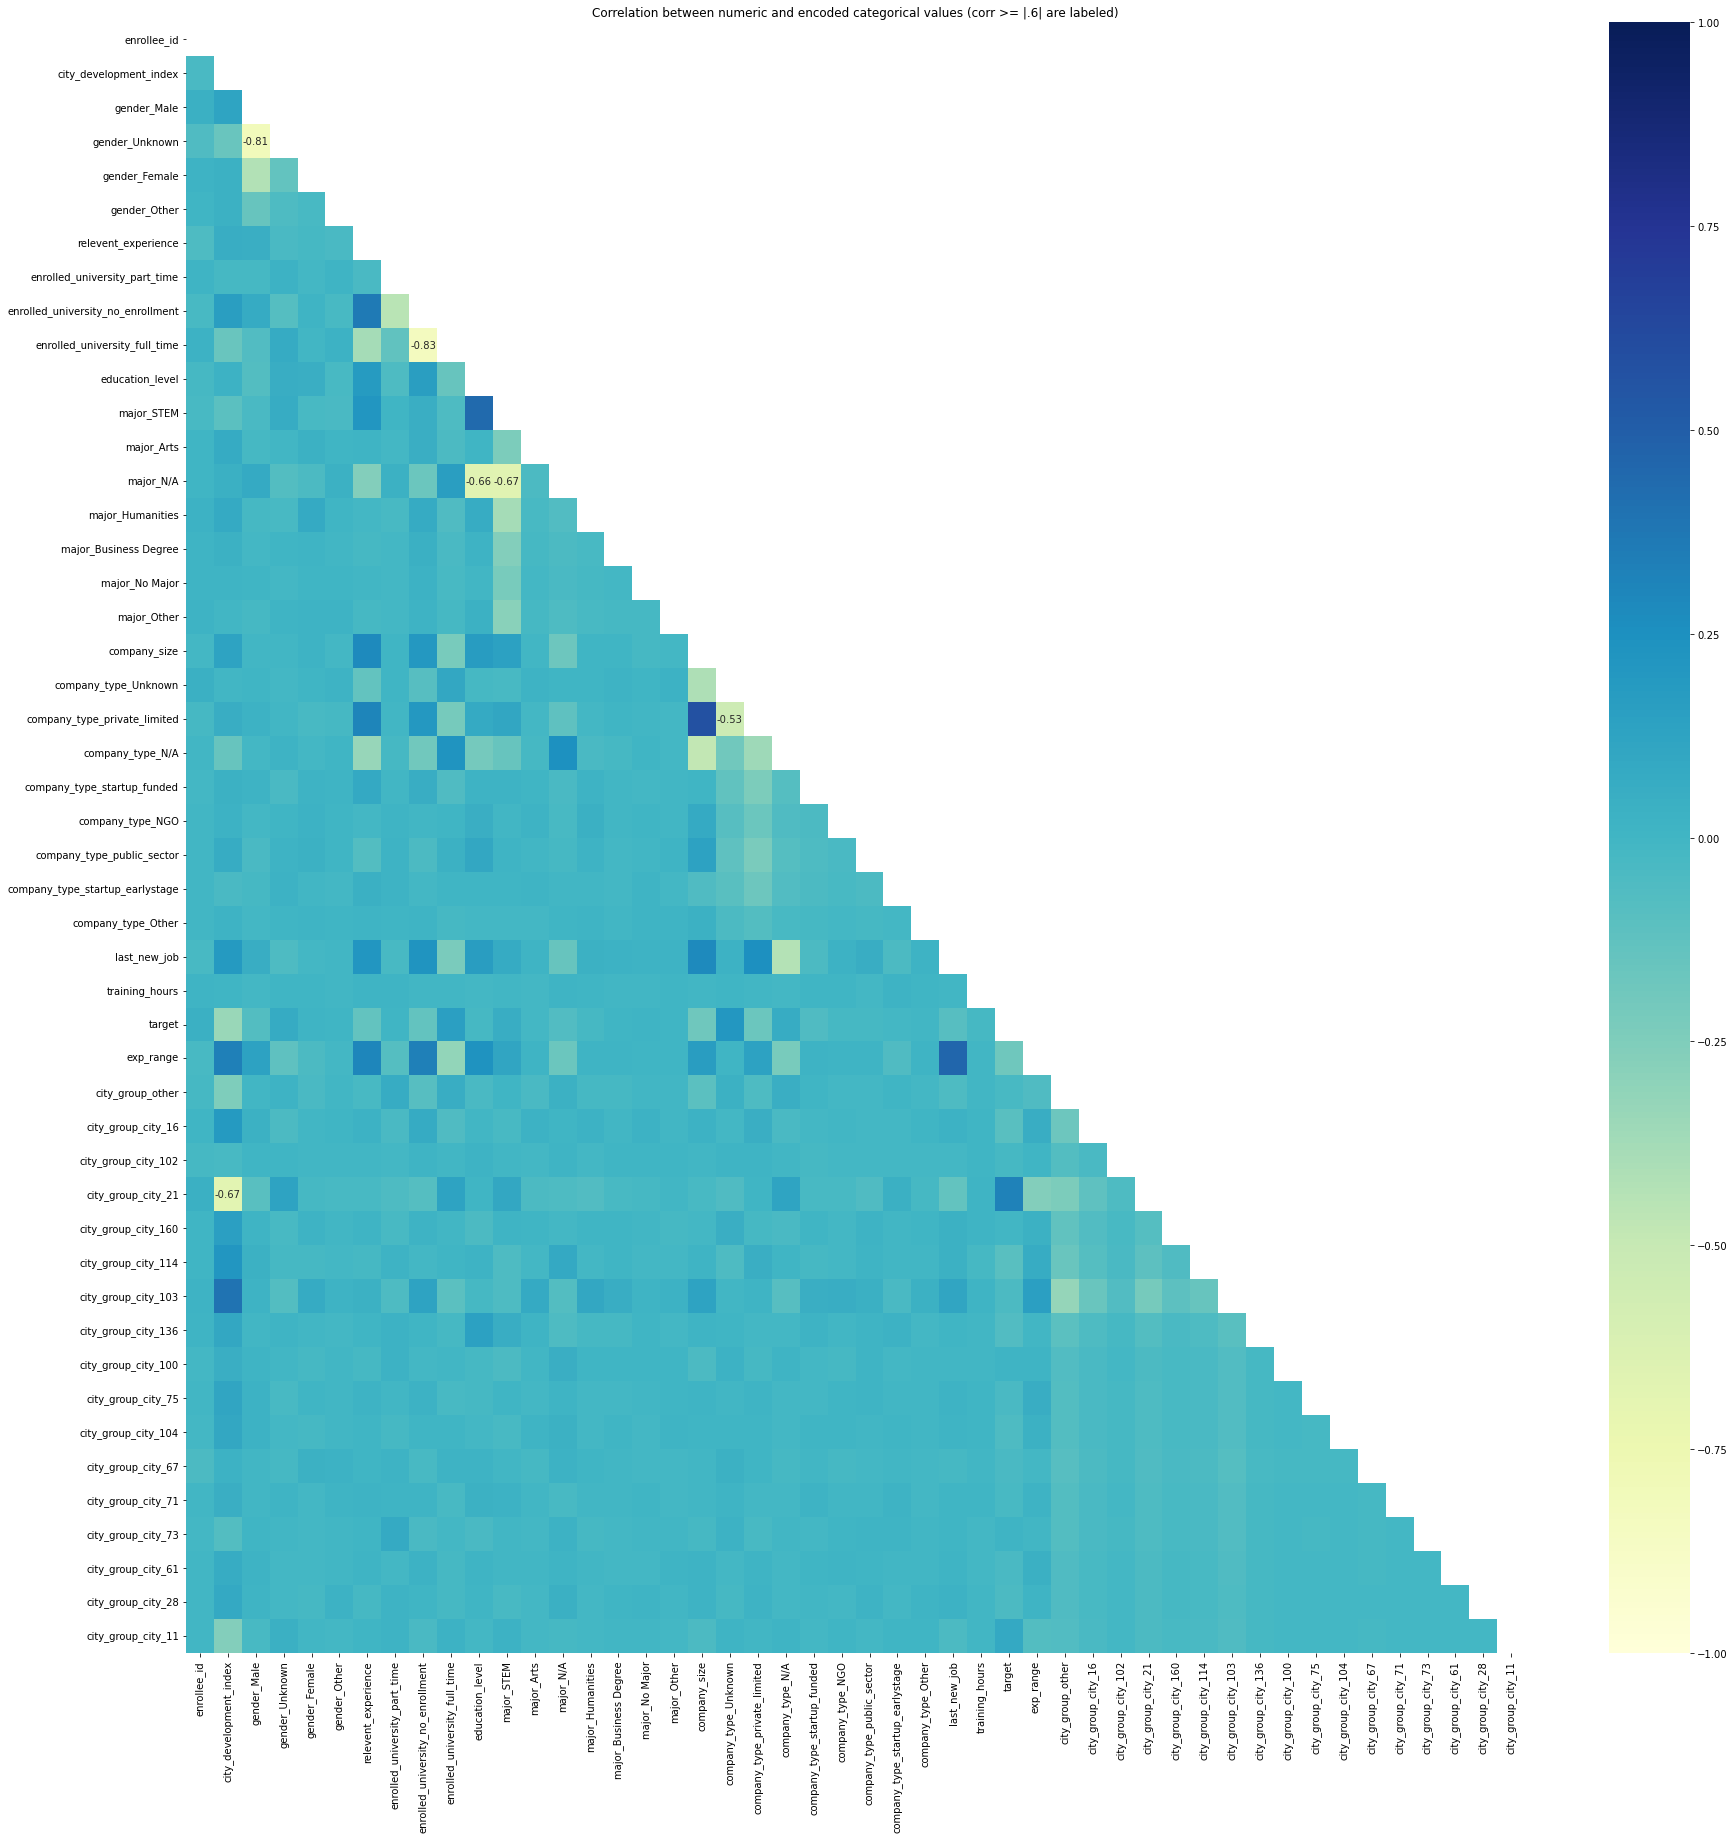

In [64]:
# Mask to only annotate correlations greater than abs .6
mask = (train.corr()>=.6) | (train.corr()<=-.5)
annotations = np.array(round(train.corr(), 2)[mask].astype(str))
annotations[np.isnan(train.corr()[mask])] = ""

matrix = np.triu(train.corr())

# Plot
plt.figure(figsize=(30,30))
x = sns.heatmap(train.corr(), annot=annotations, cmap='YlGnBu', vmin=-1, vmax=1, fmt='', mask=matrix);
x.set_title('Correlation between numeric and encoded categorical values (corr >= |.6| are labeled)');

There seems to be some multicollinearity between one-hot encoded columns. For correlation coefficients above |.60|, one column will be dropped.

These are:
- gender_Uknown * gender_male
- enrolled_full_time * no_enrollment
- Major N/A and education_level + major_STEM
- city_21 and CDI

In [69]:
train.drop(columns=['gender_Unknown', 'enrolled_university_no_enrollment', 'major_N/A', 'city_group_city_21'], inplace=True)
test.drop(columns=['gender_Unknown', 'enrolled_university_no_enrollment', 'major_N/A', 'city_group_city_21'], inplace=True)
final_eval_df.drop(columns=['gender_Unknown', 'enrolled_university_no_enrollment', 'major_N/A', 'city_group_city_21'], inplace=True)

# VI. Save Train, Test, and Final Eval Data

In [71]:
train.shape, test.shape

((13710, 44), (4570, 44))

In [72]:
train.to_csv('../data/Train.csv')
test.to_csv('../data/Test.csv')

In [73]:
final_eval_df.shape

(2129, 44)

In [74]:
final_eval_df.to_csv('../data/Final_Eval.csv')